# Binary Departure Delay Classification 

Problem Statement:
- To Predict whether or not the departure delay on an Origin-Destination pair, with a 6-hour prediction horizon, will exceed a 15 min threshold; such that the future delay will fall into one of two classes, ‘above threshold’ (1) and ‘below threshold’ (0).

Potential Clients:
- Airtraffic Controller Services and Commercial Airlines which seek to alleviate the costs that result from avoidable propagated flight delays in congested networks.

Background:
- 15 minutes is the threshold being utilized in the binary example as that is what the Bureau of Transportation Statistics considers when classifying a commercial airline flight as delayed

- The dataset consists of a sample of all commercial flights from four months of 2016, which were then aggregated by Origin-Destination Pairs and hour of day, to create a mock air-traffic network.

#### Initialization

In [1]:
%store -r features links_d
%matplotlib inline
import joblib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scikitplot as skplt
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import RobustScaler

In [4]:
#define function to partition data into standardized train and test sets
def train_test_scaled(df, featurenames, target, size, scaler, standardize=False):   
    subdf=df[featurenames].reset_index(drop=True)
    if standardize:
        scale = scaler.fit(subdf)
        subdfstd = scale.transform(subdf)
    else: 
        subdfstd=df
    X=subdfstd
    y=df[target].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, stratify=y)
    return X_train, X_test, y_train, y_test, scale

In [2]:
#define function to get values for classifier predictions
def get_pred_prob(clf, Xtr, Xts):
    ytr_pred = clf.predict(Xtr)
    yts_pred = clf.predict(Xts)
    yts_prob = clf.predict_proba(Xts)
    return ytr_pred, yts_pred, yts_prob

In [3]:
#define function to get scores for classifier
def classification_metrics(clf, Xtr, ytr, ytr_pred, Xts, yts, yts_pred):
    train_scores = cross_val_score(clf, Xtr, ytr, cv=5)
    test_scores = cross_val_score(clf, Xts, yts, cv=5)
    print('-'*52)
    print('CV-Accuracy on training data: {:0.4f} (+/- {:0.4f})'.format(train_scores.mean(), train_scores.std() * 2))
    print('CV-Accuracy on test data: {:0.4f} (+/- {:0.4f})'.format(test_scores.mean(), test_scores.std() * 2))
    print('-'*52)
    print("[Training Classification Report]")
    print(classification_report(ytr, ytr_pred))
    print('-'*52)
    print("[Test Classification Report]")
    print(classification_report(yts, yts_pred))
    print('-'*52)

In [6]:
#define function to plot metrics for Logistic Regression model
def logreg_metrics_plots(clf, Xtr, ytr, Xts, yts, yts_pred, yts_probs):
    fig, axes = plt.subplots(nrows=7, figsize=(9, 30))
    skplt.metrics.plot_cumulative_gain(yts, yts_probs, ax=axes[0])
    skplt.metrics.plot_lift_curve(yts, yts_probs, ax=axes[1])
    skplt.metrics.plot_ks_statistic(yts, yts_probs, ax=axes[2])
    skplt.metrics.plot_roc(yts, yts_probs, ax=axes[3])
    skplt.metrics.plot_precision_recall(yts, yts_probs, ax=axes[4])
    skplt.metrics.plot_calibration_curve(yts,[yts_probs],['Logistic Regression'], ax=axes[5])
    skplt.metrics.plot_confusion_matrix(yts, yts_pred, normalize=True, ax=axes[6])
    fig.tight_layout()
    plt.show()

In [1]:
#define function to plot metrics for Random Forest Classifier
def randforest_metrics_plots(clf, Xtr, ytr, Xts, yts, yts_pred, yts_probs):
    fig, axes = plt.subplots(nrows=4, figsize=(9, 20))
    skplt.metrics.plot_roc(yts, yts_probs, ax=axes[0])
    skplt.metrics.plot_precision_recall(yts, yts_probs, ax=axes[1])
    skplt.metrics.plot_calibration_curve(yts,[yts_probs],['Random Forest'], ax=axes[2])
    skplt.metrics.plot_confusion_matrix(yts, yts_probs, normalize=True, ax=axes[3])
    fig.tight_layout()
    plt.show()

## Baseline model utilizing Logistic Regression

In [5]:
#split data into standardized train and test sets
X_train, X_test, y_train, y_test, scale = train_test_scaled(links_d, features,'dd_binary', 0.3,
                                                            RobustScaler(), standardize=True)

In [ ]:
#store train/test splits for binary classification
for k, v in {'Xtrain': X_train, 'Xtest': X_test, 'ytrain': y_train, 'ytest': y_test, 'scale': scale}.items():
    joblib.dump(v, 'CP1_binary_{}.pkl'.format(k)) 

In [5]:
#load test splits and scale object for binary classification
X_test = joblib.load('CP1_binary_Xtest.pkl')
y_test = joblib.load('CP1_binary_ytest.pkl')

In [6]:
#fit training data to Logistic Regression estimator without regularization
lr = LogisticRegression().fit(X_train, y_train)

In [8]:
#get values for unregularized model predictions
y_train_pred, y_test_pred, y_test_prob = get_pred_prob(lr, X_train, X_test)
    
#get classification metrics for unregularized model
print('Classification Metrics for Unregularized Logistic Regression Model')
classification_metrics(lr, X_train, y_train, y_train_pred, X_test, y_test, y_test_pred)

Classification Metrics on Unregularized Model
----------------------------------------------------
Accuracy on training data: 0.7721 (+/- 0.0000)
Accuracy on test data: 0.7721 (+/- 0.0000)
----------------------------------------------------
[Training Classification Report]
             precision    recall  f1-score   support

          0       0.77      1.00      0.87    477153
          1       0.00      0.00      0.00    140817

avg / total       0.60      0.77      0.67    617970

----------------------------------------------------
[Test Classification Report]
             precision    recall  f1-score   support

          0       0.77      1.00      0.87    204495
          1       0.00      0.00      0.00     60350

avg / total       0.60      0.77      0.67    264845

----------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Test Set Results with Unregularized Logistic Regression


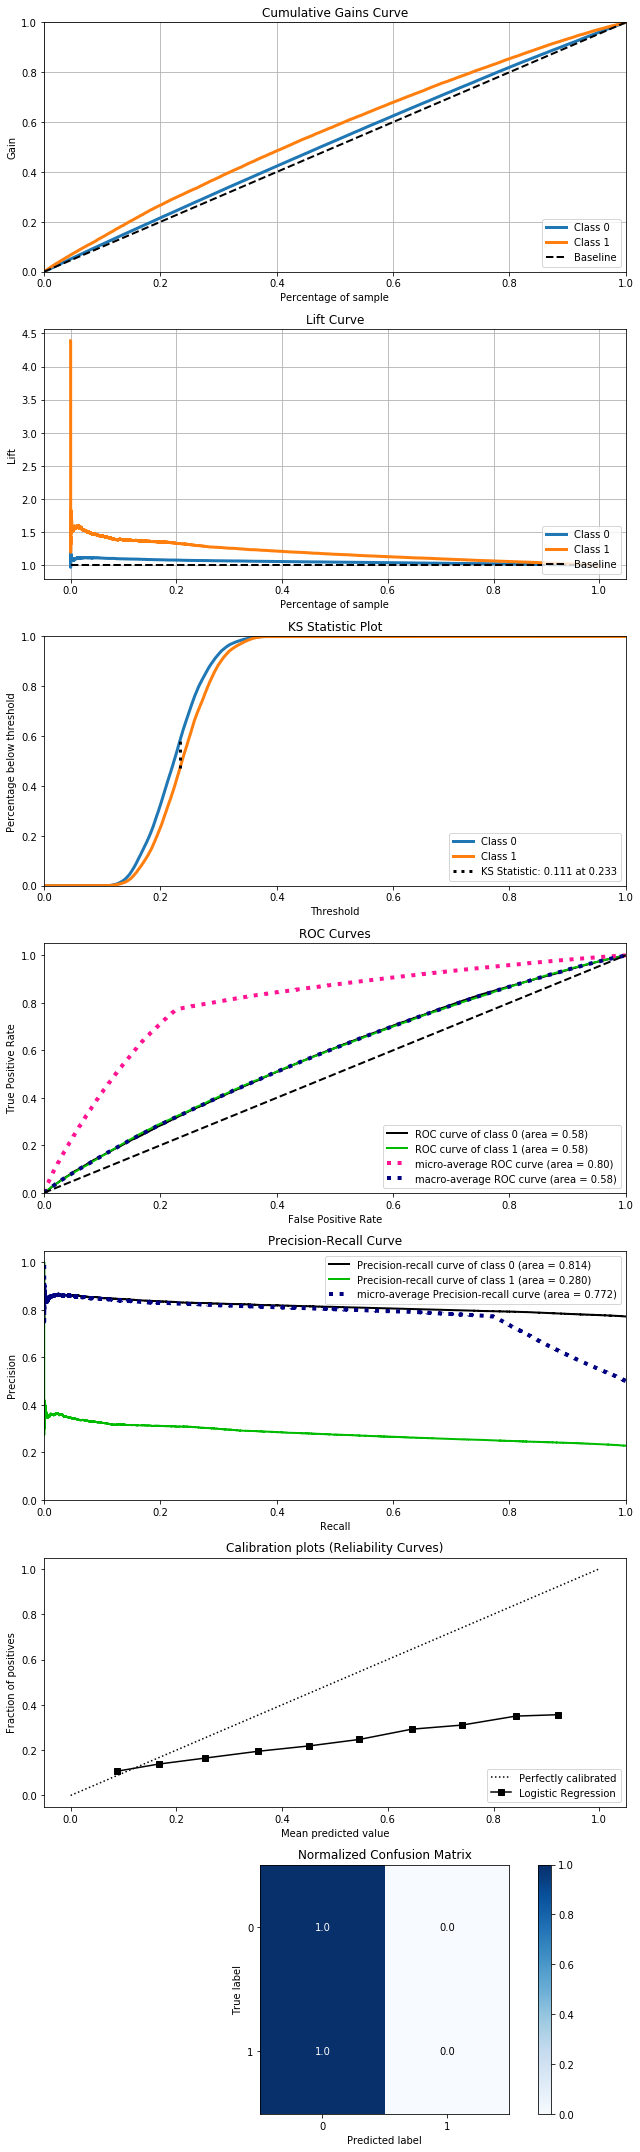

In [10]:
#plot metrics of unregularized model
print('Test Set Results with Unregularized Logistic Regression')
logreg_metrics_plots(lr, X_train, y_train, X_test, y_test, y_test_pred, y_test_prob)

##### Results:
- Due to the imbalanced distribution of the delayed class (22.7% of total dataset) the classifier performed very poorly in predicting true positives
- Accuracy was deemed to be an inappropriate evaluation metric in this case, with the individual Precision, Recall, and F1-scores for each class being more indicative of model performance.

## Resampling to counter dataset imbalance
- Utilize Under- and Over- sampling techniques on the training dataset
- Train each method on RandomForest and Logistic Regression classifiers
- Test Classifiers under both conditions and perform cross-validation with the test set containing the natural distribution of classes
- Assess model performance with Precision, Recall, F-1, and AUC scores.  Particularly the Area under the ROC curve statistic, as it is equal to the probability that a random positive example will be ranked above a random negative example, and the Precision-Recall curve as a visual metric.

### Condition 1: Under-sampling

In [6]:
from imblearn.under_sampling import RandomUnderSampler

#under sample training and test sets
Xtr_rus, ytr_rus = RandomUnderSampler(random_state=42).fit_sample(X_train, y_train)

#show resample shape vs original shape
print('Original target shape:  {}'.format(Counter(y_train)))
print('Resampled target shape:  {}'.format(Counter(ytr_rus)))

Original target shape:  Counter({0: 477153, 1: 140817})
Resampled target shape:  Counter({0: 140817, 1: 140817})


In [15]:
#store undersampled training data for binary classification
for k, v in {'Xtr_rus': Xtr_rus, 'ytr_rus': ytr_rus}.items():
    joblib.dump(v, 'CP1_binary_{}.pkl'.format(k)) 

In [6]:
#load undersampled training data for binary classification
Xtr_rus = joblib.load('CP1_binary_Xtr_rus.pkl')
ytr_rus = joblib.load('CP1_binary_ytr_rus.pkl')

#### Logistic Regression Classifier with Undersampled dataset

In [15]:
#train logistic regression
lr_rus = LogisticRegression().fit(Xtr_rus, ytr_rus)

In [16]:
#get values for undersampled logistic regression model predictions
ytr_rus_pred, yts_rus_pred, yts_rus_prob = get_pred_prob(lr_rus, Xtr_rus, X_test)

#get classification metrics for undersampled logistic regression model
print('Classification Metrics on Undersampled Logistic Regression Model')
classification_metrics(lr_rus, Xtr_rus, ytr_rus, ytr_rus_pred, X_test, y_test, yts_rus_pred)

Classification Metrics on Undersampled Logistic Regression Model
----------------------------------------------------
Accuracy on training data: 0.5540 (+/- 0.0050)
Accuracy on test data: 0.7721 (+/- 0.0000)
----------------------------------------------------
[Training Classification Report]
             precision    recall  f1-score   support

          0       0.56      0.54      0.55    140817
          1       0.56      0.58      0.57    140817

avg / total       0.56      0.56      0.56    281634

----------------------------------------------------
[Test Classification Report]
             precision    recall  f1-score   support

          0       0.81      0.53      0.64    204495
          1       0.27      0.57      0.36     60350

avg / total       0.69      0.54      0.58    264845

----------------------------------------------------


Test Set Results with Undersampled Logistic Regression Model


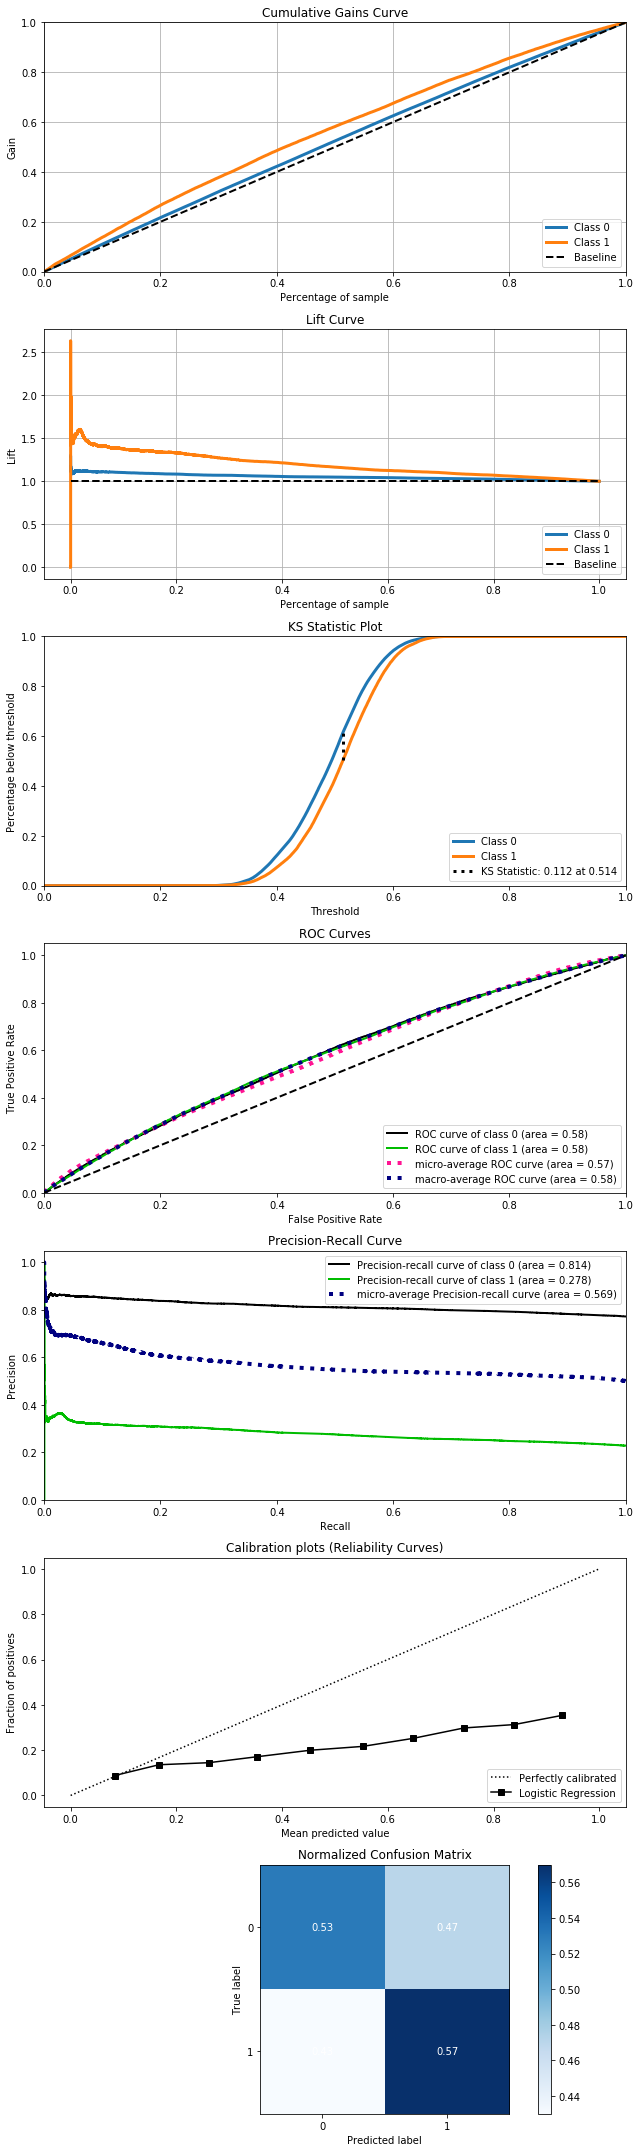

In [17]:
#plot metrics of undersampled lr model
print('Test Set Results with Undersampled Logistic Regression Model')
logreg_metrics_plots(lr_rus, Xtr_rus, ytr_rus, X_test, y_test, yts_rus_pred, yts_rus_prob)

#### Random Forest Classifier with Undersampled dataset

In [7]:
#create hyperparameter grid
rf_params = {'n_estimators':  [100], 'max_features':[0.2, 'log2', 0.4]}

#Random Forest Classifier on undersampled training data using GridSearchCV
GSCV_Rf_rus = GridSearchCV(RandomForestClassifier(), rf_params, n_jobs=2, cv=3).fit(Xtr_rus, ytr_rus)

In [8]:
#get best Random forest estimator from GSCV 
best_Rf_rus = GSCV_Rf_rus.best_estimator_

#Show results of RandomForest GSCV on undersampled dataset
print("Tuned Model Parameters: {}".format(GSCV_Rf_rus.best_params_))
print("Best GSCV score on Training Set: {:0.4f}".format(GSCV_Rf_rus.best_score_))

Tuned Model Parameters: {'max_features': 'log2', 'n_estimators': 100}
Best GSCV score on Training Set: 0.7398


In [9]:
#store Random Forest Classifier trained on Undersampled Data
joblib.dump(best_Rf_rus, 'CP1_binary_RandomForestClassifier_rus.pkl')

['CP1_binary_RandomForestClassifier_rus.pkl']

In [10]:
#load Random Forest Classifier trained on Undersampled Data
#best_Rf_rus = joblib.load('CP1_binary_RandomForestClassifier_rus.pkl')

In [12]:
#get predicted values for best RandomForest estimator on undersampled dataset
ytr_rus_pred, yts_rus_pred, yts_rus_prob = get_pred_prob(best_Rf_rus, Xtr_rus, X_test)

#get classification metrics for best RandomForest GSCV estimator
print('Classification Metrics for Undersampled Random Forest Classifier')
classification_metrics(best_Rf_rus, Xtr_rus, ytr_rus, ytr_rus_pred, X_test, y_test, yts_rus_pred)

Classification Metrics for Undersampled Random Forest Classifier
----------------------------------------------------
CV-Accuracy on training data: 0.7525 (+/- 0.0024)
CV-Accuracy on test data: 0.8093 (+/- 0.0011)
----------------------------------------------------
[Training Classification Report]
             precision    recall  f1-score   support

          0       0.94      0.93      0.94    140817
          1       0.93      0.94      0.94    140817

avg / total       0.94      0.94      0.94    281634

----------------------------------------------------
[Test Classification Report]
             precision    recall  f1-score   support

          0       0.92      0.76      0.83    204495
          1       0.49      0.77      0.60     60350

avg / total       0.82      0.76      0.78    264845

----------------------------------------------------


Test Set Results with Undersampled Random Forest Classifier


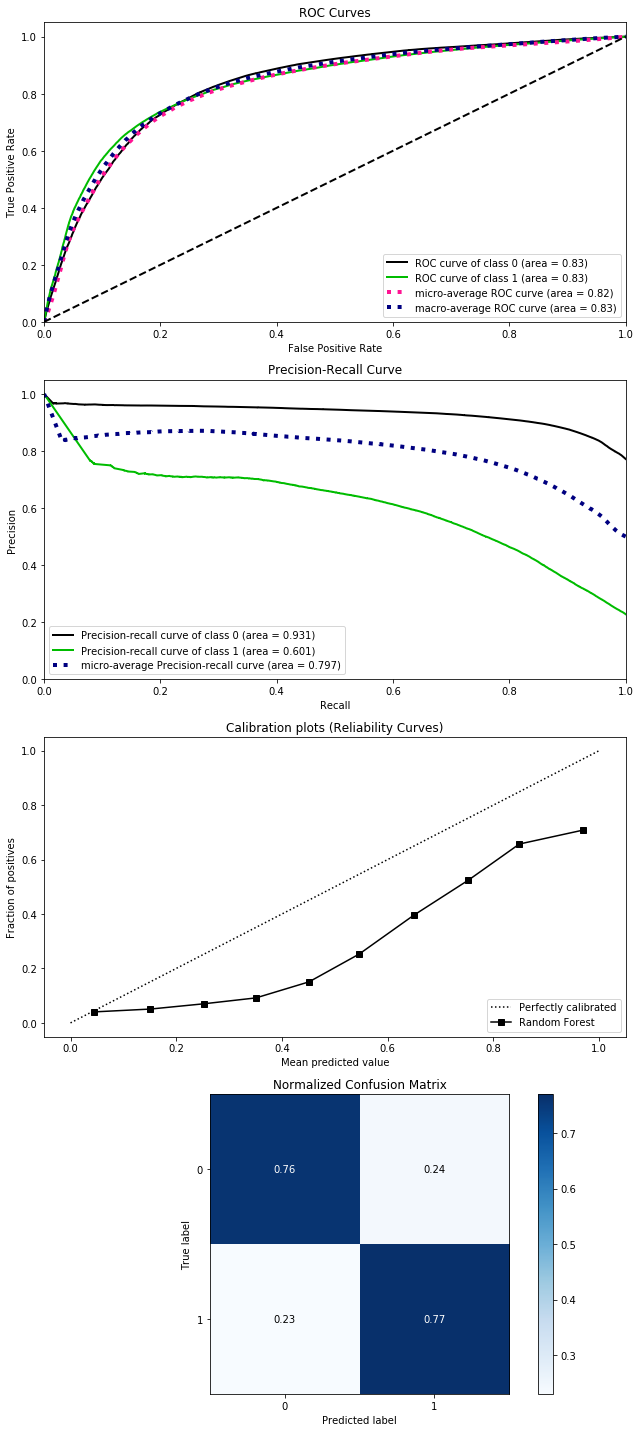

In [13]:
#plot metrics of undersampled RandomForest Classifier
print('Test Set Results with Undersampled Random Forest Classifier')
randforest_metrics_plots(best_Rf_rus, Xtr_rus, ytr_rus, X_test, y_test, yts_rus_pred, yts_rus_prob)

### Condition 2: Over-sampling

In [17]:
from imblearn.over_sampling import SMOTE

#under sample training and test sets
Xtr_smote, ytr_smote = SMOTE(ratio='minority', n_jobs=2).fit_sample(X_train, y_train)

#show resample shape vs original shape
print('Original target shape:  {}'.format(Counter(y_train)))
print('Resampled target shape:  {}'.format(Counter(ytr_smote)))

Original target shape:  Counter({0: 477153, 1: 140817})
Resampled target shape:  Counter({0: 477153, 1: 477153})


In [18]:
#store oversampled training data for binary classification
for k, v in {'Xtr_smote': Xtr_smote, 'ytr_smote': ytr_smote}.items():
    joblib.dump(v, 'CP1_binary_{}.pkl'.format(k)) 

In [6]:
#load oversampled training data for binary classification
Xtr_smote = joblib.load('CP1_binary_Xtr_smote.pkl')
ytr_smote = joblib.load('CP1_binary_ytr_smote.pkl')

#### Logistic Regression with Oversampled dataset

In [23]:
#train logistic regression
lr_smote = LogisticRegression().fit(Xtr_smote, ytr_smote)

In [24]:
#get values for oversampled logistic regression model predictions
ytr_smote_pred, yts_smote_pred, yts_smote_prob = get_pred_prob(lr_smote, Xtr_smote, X_test)
    
#get classification metrics for oversampled logistic regression model
print('Classification Metrics on Oversampled Logistic Regression Model')
classification_metrics(lr_smote, Xtr_smote, ytr_smote, ytr_smote_pred, X_test, y_test, yts_smote_pred)

Classification Metrics on Oversampled Logistic Regression Model
----------------------------------------------------
Accuracy on training data: 0.5570 (+/- 0.0012)
Accuracy on test data: 0.7721 (+/- 0.0000)
----------------------------------------------------
[Training Classification Report]
             precision    recall  f1-score   support

          0       0.56      0.54      0.55    477153
          1       0.56      0.58      0.57    477153

avg / total       0.56      0.56      0.56    954306

----------------------------------------------------
[Test Classification Report]
             precision    recall  f1-score   support

          0       0.81      0.54      0.65    204495
          1       0.27      0.57      0.36     60350

avg / total       0.69      0.55      0.58    264845

----------------------------------------------------


Test Set Results with Oversampled Logistic Regression Model


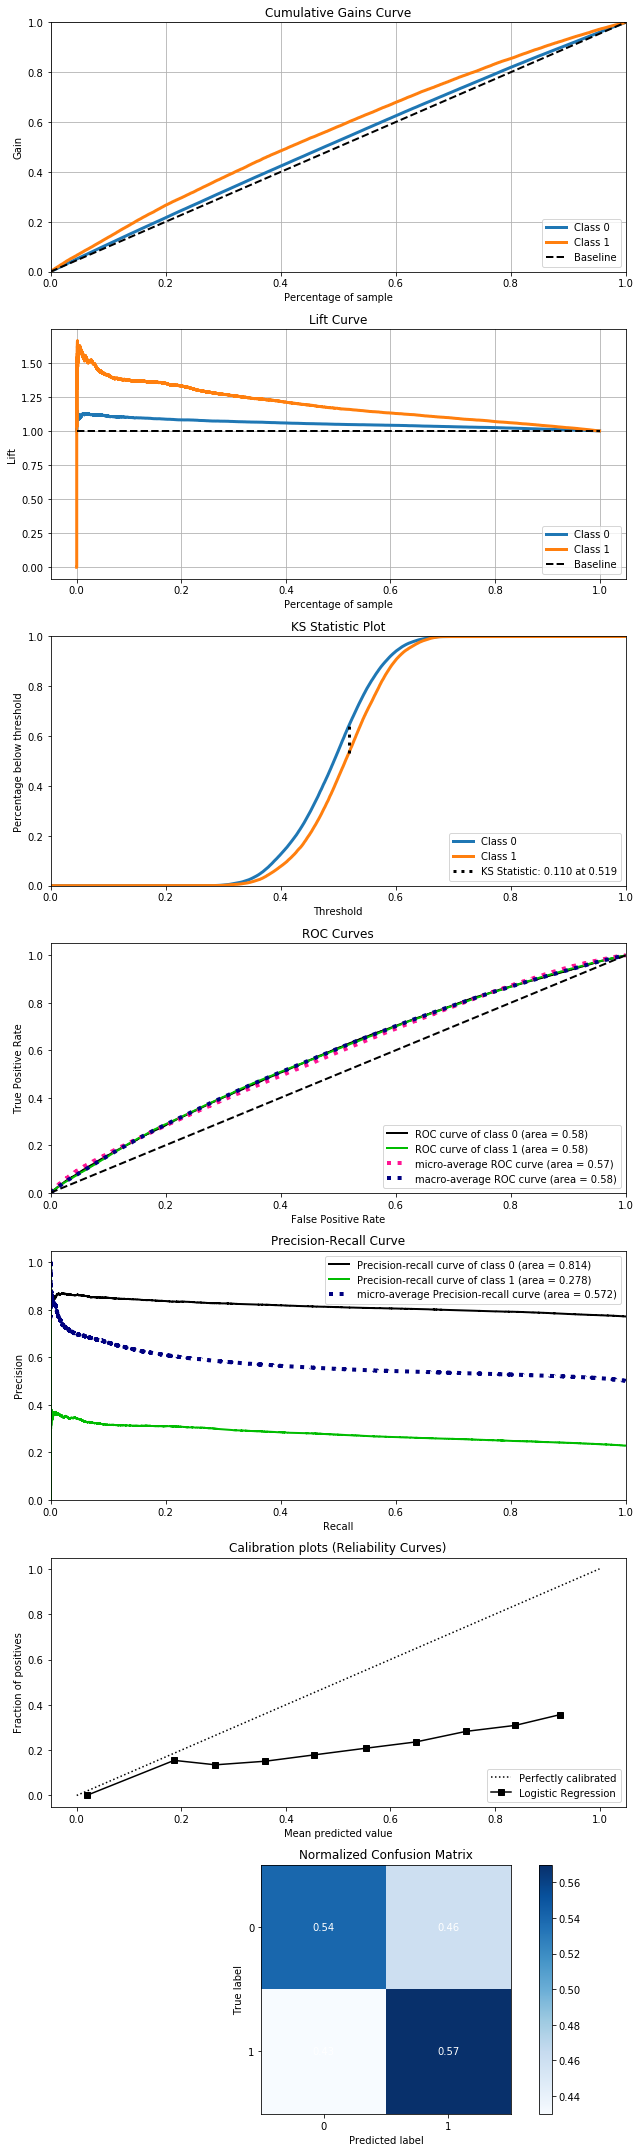

In [25]:
#plot metrics of oversampled lr model
print('Test Set Results with Oversampled Logistic Regression Model')
logreg_metrics_plots(lr_smote, Xtr_smote, ytr_smote, X_test, y_test, yts_smote_pred, yts_smote_prob)

#### Random Forest Classifier with Oversampled dataset

In [6]:
#create hyperparameter grid
rf_params = {'n_estimators': [100], 'max_features':[0.2, 'log2', 0.4]}

#Random Forest Classifier on  oversampled training data using GridSearchCV
GSCV_Rf_smote = GridSearchCV(RandomForestClassifier(), rf_params, n_jobs=2, cv=3).fit(Xtr_smote, ytr_smote)

In [7]:
#get best Random forest estimator from GSCV 
best_Rf_smote = GSCV_Rf_smote.best_estimator_

#Show results of RandomForest GSCV on oversampled dataset
print("Tuned Model Parameters: {}".format(GSCV_Rf_smote.best_params_))
print("Best GSCV score on Training Set: {:0.4f}".format(GSCV_Rf_smote.best_score_))

Tuned Model Parameters: {'max_features': 'log2', 'n_estimators': 100}
Best GSCV score on Training Set: 0.8963


In [8]:
#store Random Forest Classifier trained on Oversampled Data
joblib.dump(best_Rf_smote, 'CP1_binary_RandomForestClassifier_smote.pkl')

['CP1_binary_RandomForestClassifier_smote.pkl']

In [7]:
#load Random Forest Classifier trained on Oversampled Data
best_Rf_smote = joblib.load('CP1_binary_RandomForestClassifier_smote.pkl')

In [8]:
#get predicted values for best RandomForest estimator on oversampled dataset
ytr_smote_pred, yts_smote_pred, yts_smote_prob = get_pred_prob(best_Rf_smote, Xtr_smote, X_test)

#get classification metrics for best RandomForest GSCV estimator
print('Classification Metrics for Oversampled Random Forest Classifier')
classification_metrics(best_Rf_smote, Xtr_smote, ytr_smote, ytr_smote_pred, X_test, y_test, yts_smote_pred)

Classification Metrics for Oversampled Random Forest Classifier
----------------------------------------------------
CV-Accuracy on training data: 0.9033 (+/- 0.1082)
CV-Accuracy on test data: 0.8091 (+/- 0.0028)
----------------------------------------------------
[Training Classification Report]
             precision    recall  f1-score   support

          0       0.96      0.95      0.95    477153
          1       0.95      0.96      0.95    477153

avg / total       0.95      0.95      0.95    954306

----------------------------------------------------
[Test Classification Report]
             precision    recall  f1-score   support

          0       0.89      0.91      0.90    204495
          1       0.67      0.60      0.64     60350

avg / total       0.84      0.84      0.84    264845

----------------------------------------------------


Test Set Results with Oversampled Random Forest Classifier


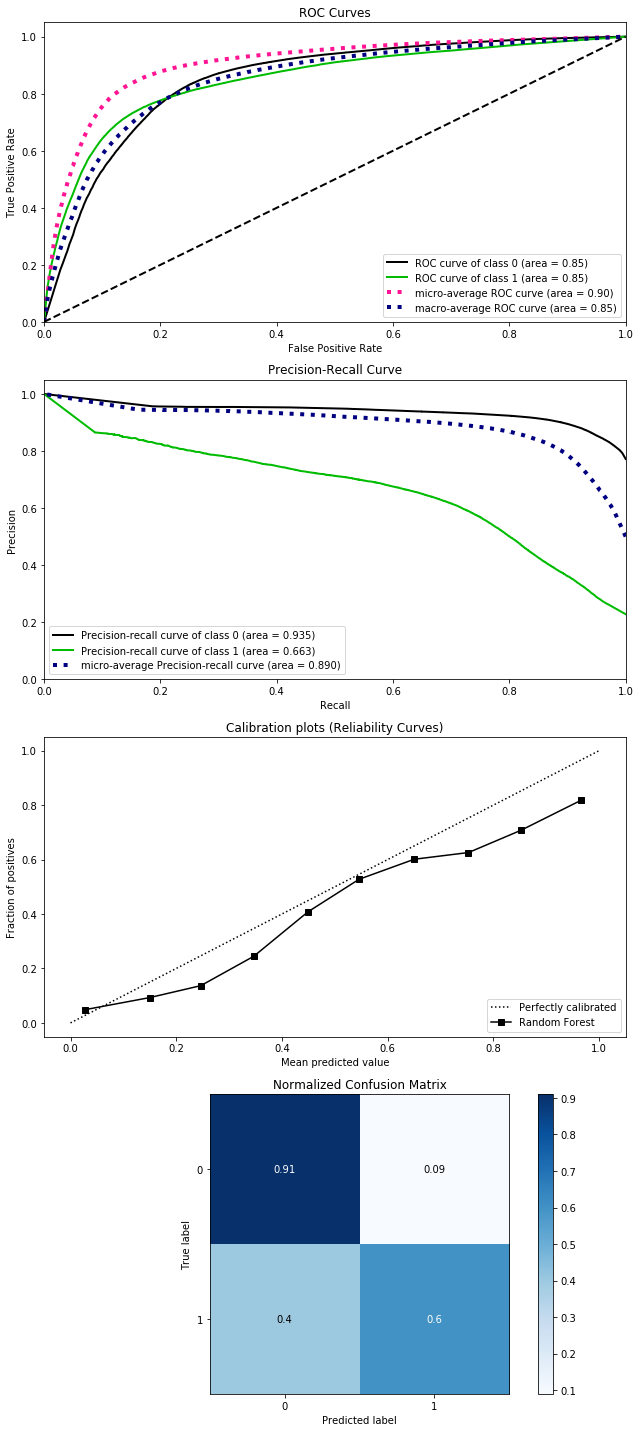

In [9]:
#plot metrics of oversampled randomforest classifier
print('Test Set Results with Oversampled Random Forest Classifier')
randforest_metrics_plots(best_Rf_smote, Xtr_smote, ytr_smote, X_test, y_test, yts_smote_pred, yts_smote_prob)

#### Results:
- Utilizing the AUC score as the primary comparative statistic for model performance, the RandomForest Classifier trained on data oversampled using SMOTE (Synthetic Minority Oversampling Technique) performed best, with an AUC of 0.85, a Precision score for the delay class of 0.67, and an F1-score of 0.64.
- The Random Forest Classifier trained on data using the Random Under Sampling technique had a higher Recall score for the delay class (0.77), but considerably lower Precision, with a score of 0.49. Meaning it had a lower false positive rate, but of the additional results being returned, most had incorrect labels in comparison to the training labels. 
- Overall, of the two four estimators trained, the logistic regression models performed the worst, proving unreliable for this particular problem, although they might potentially be improved if weights were added to the classes. Therefore, the ensemble approach appears to more approriate for this problem moving forward, and of the two Random Forest Classifiers, the one trained on the SMOTE training set yielded the most useful results.